<h1>Predict Customer Spending Score</h1>
<h3>-> Low: 0, Average: 1, High: 2</h3>

In [3]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Combine CSVs
csv1 = pd.read_csv("drive/My Drive/Colab Notebooks/Predict Customer Spending Score/Test.csv")
csv2 = pd.read_csv("drive/My Drive/Colab Notebooks/Predict Customer Spending Score/Customers.csv")

dataframe = pd.concat( [csv1, csv2], ignore_index = True )
dataframe = dataframe.drop(["ID", "Segmentation", "Var_1"] , axis = 1)
dataframe.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,Female,Yes,69,No,NaN,0.0,Low,1.0
3,Male,Yes,59,No,Executive,11.0,High,2.0
4,Female,No,19,No,Marketing,NaN,Low,4.0


In [6]:
# Fill na with mode
ever_married_mode = dataframe['Ever_Married'].mode()[0]
dataframe['Ever_Married'] = dataframe['Ever_Married'].fillna(ever_married_mode)

graduated_mode = dataframe['Graduated'].mode()[0]
dataframe['Graduated'] = dataframe['Graduated'].fillna(graduated_mode)

Profession_mode = dataframe['Profession'].mode()[0]
dataframe['Profession'] = dataframe['Profession'].fillna(Profession_mode)

# Fill na with mean
Work_Experience_mean = int(dataframe['Work_Experience'].mean())
dataframe['Work_Experience'] = dataframe['Work_Experience'].fillna(Work_Experience_mean)

Family_Size_mean = int(dataframe['Family_Size'].mean())
dataframe['Family_Size'] = dataframe['Family_Size'].fillna(Family_Size_mean)

In [7]:
# label encode categorical data
dataframe['Gender'] = dataframe['Gender'].map({'Male': 1, 'Female': 0})
dataframe['Ever_Married'] = dataframe['Ever_Married'].map({'Yes': 1, 'No': 0})
dataframe['Graduated'] = dataframe['Graduated'].map({'Yes': 1, 'No': 0})
dataframe['Spending_Score'] = dataframe['Spending_Score'].map({'Low': 0, 'Average': 1, 'High': 2})

# One Hot Encode categorical data
profession_dummies = pd.get_dummies(dataframe['Profession'], prefix='Profession', prefix_sep='=>', dtype=int)
dataframe = pd.concat([dataframe, profession_dummies], axis = 1)

dataframe = dataframe.drop('Profession', axis = 1)

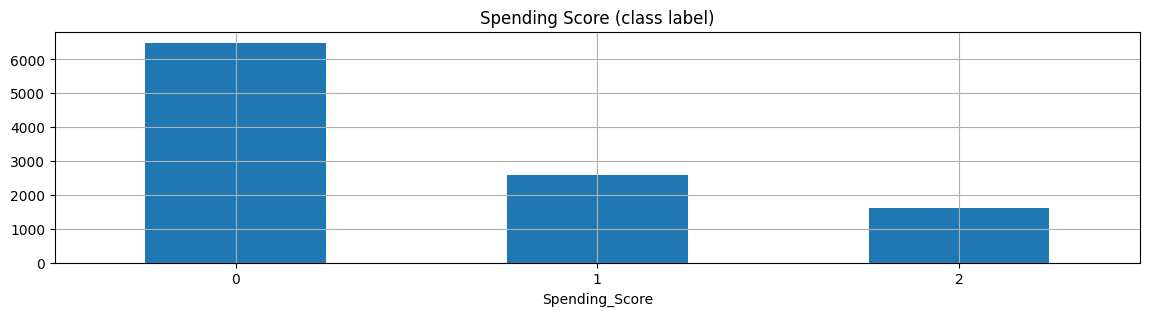

In [8]:
# Check if class label is balanced
dataframe['Spending_Score'].value_counts().plot(kind='bar', title='Spending Score (class label)', rot=0, grid=True, figsize=(14, 3))
plt.show()

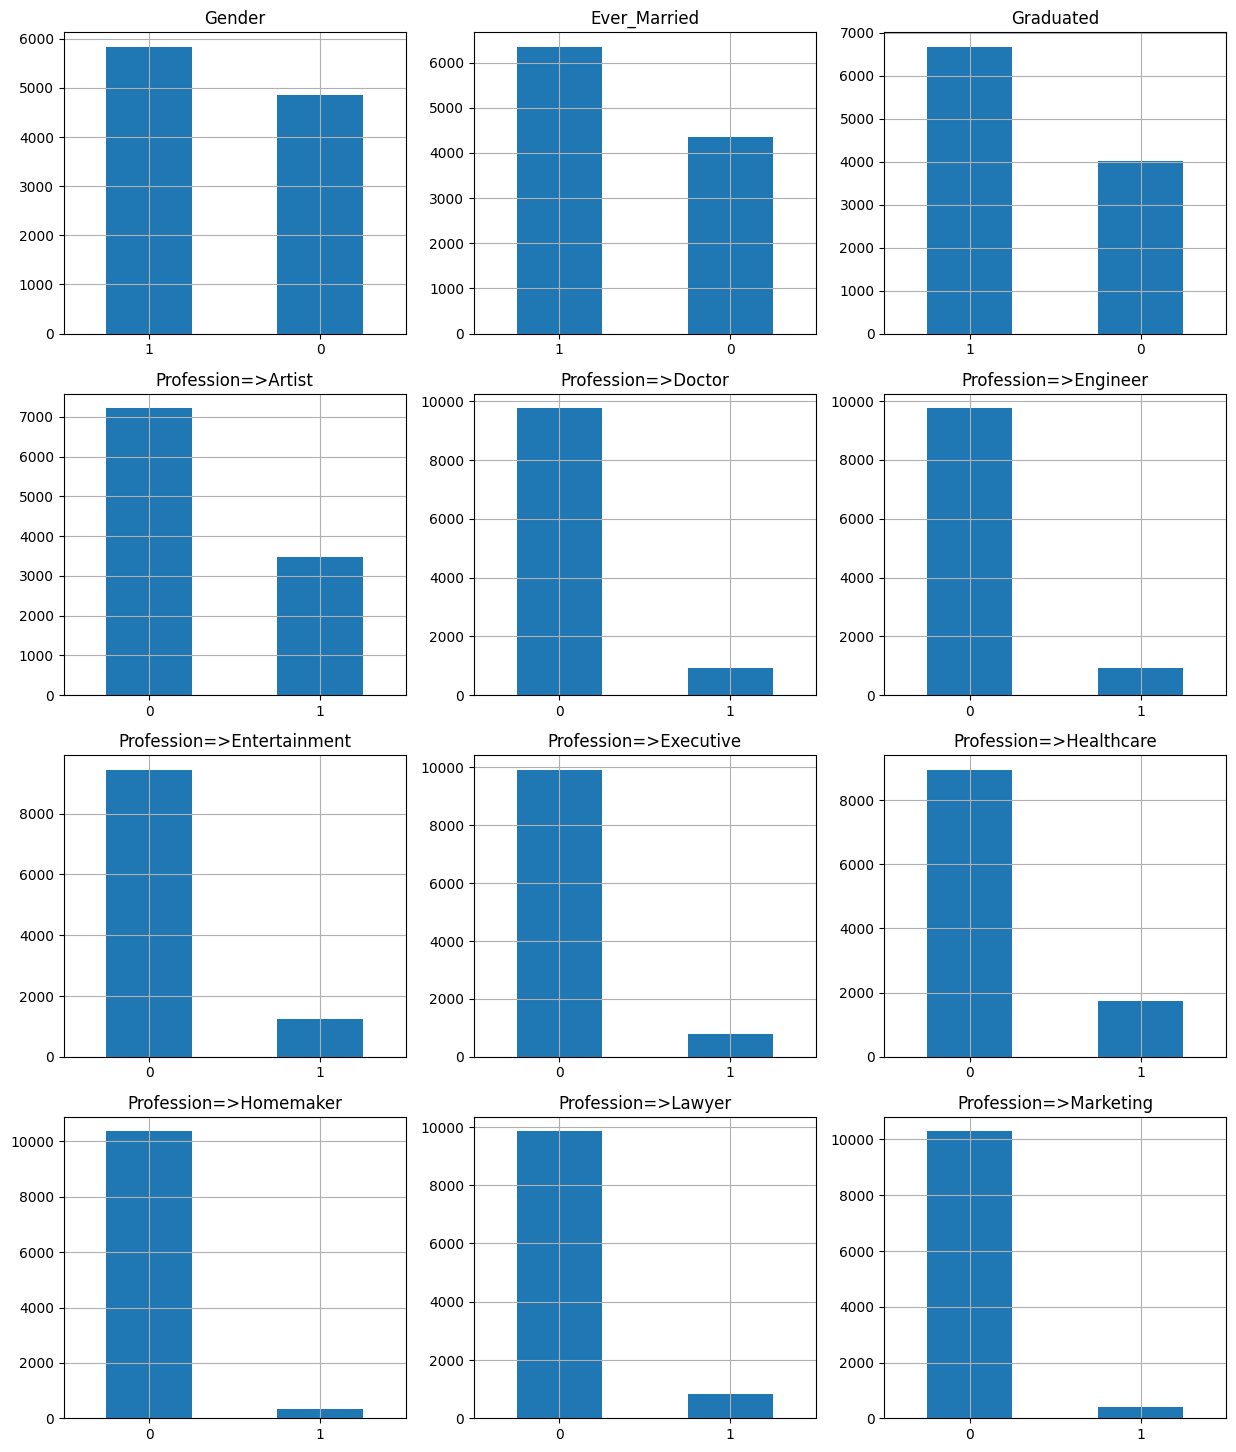

In [9]:
### Visualize the other columns
categorical_columns = list(dataframe.columns)
categorical_columns.remove('Age')
categorical_columns.remove('Work_Experience')
categorical_columns.remove('Family_Size')
categorical_columns.remove('Spending_Score')

## Plot categorical columns
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 3, figsize=(15, 18))
i_column = 0 # specifies the column
i_row = 0 # specifies the row
axes = [ax0, ax1, ax2, ax3]
for column in categorical_columns:

  # reset column index and increment row index
  if i_column == 3:
    i_column = 0
    i_row += 1

  # Plot the graph
  dataframe[column].value_counts().plot(kind='bar', ax=axes[i_row][i_column], title=column, rot=0, grid=True, xlabel='')

  # Increment column index
  i_column += 1

plt.show()

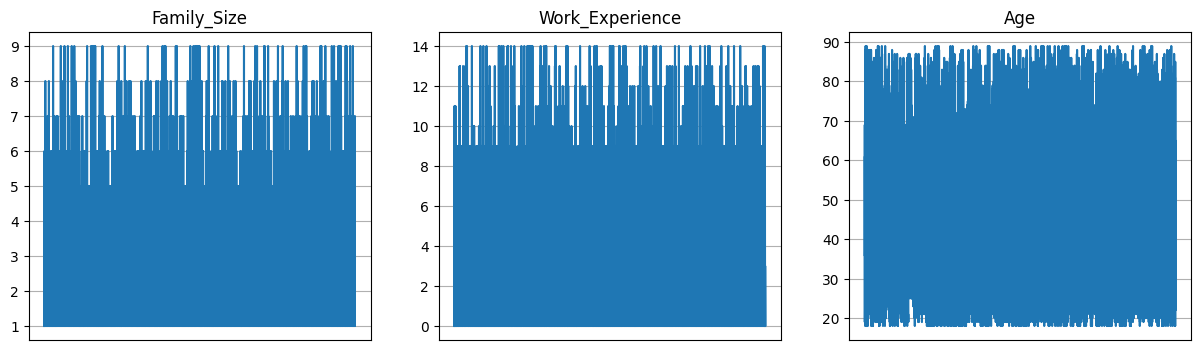

In [10]:
continuous_columns = ['Family_Size', 'Work_Experience', 'Age']

# Plot continuous columns
fig, (ax0) = plt.subplots(1, 3, figsize=(15, 4))
for index, column in enumerate(continuous_columns):
  dataframe[column].plot(kind='line', title=column, grid=True, ax=ax0[index], xticks=[])
plt.show()

In [11]:
# Separate data
features = dataframe.drop('Spending_Score', axis = 1)
label = dataframe['Spending_Score']
print(f"Features: {features.values.shape}\nLabel: {label.values.shape}")

Features: (10695, 15)
Label: (10695,)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


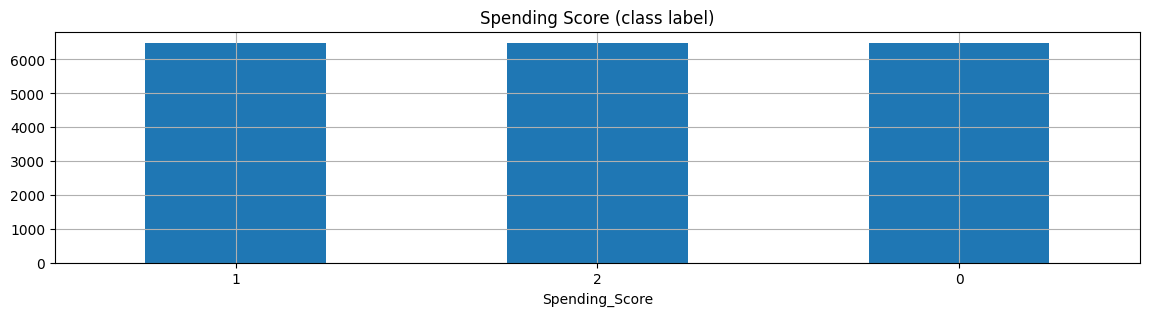

Features: (19489, 15)
Label: (19489,)


In [12]:
# Balance Data
from imblearn.over_sampling import KMeansSMOTE
over_sampler = KMeansSMOTE(k_neighbors=4, cluster_balance_threshold=0.1)
features, label = over_sampler.fit_resample(features, label)

label.value_counts().plot(kind='bar', title='Spending Score (class label)', rot=0, grid=True, figsize=(14, 3))
plt.show()

print(f"Features: {features.values.shape}\nLabel: {label.values.shape}")

In [13]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size = 0.3, stratify=label.values)

# Apply Feature Scaling
from sklearn.preprocessing import StandardScaler
training_scaler = StandardScaler()
testing_scaler = StandardScaler()

X_train = training_scaler.fit_transform(X_train)
X_test = testing_scaler.fit_transform(X_test)

# Change np.arrays to torch tensors and move them to the device being used
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

torch.Size([13642, 15]) torch.float32
torch.Size([5847, 15]) torch.float32


In [14]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [56]:
# Prepare Model

from torch import nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchmetrics.classification import Accuracy, ConfusionMatrix, F1Score, Precision, Recall

class Neural_Network(nn.Module):
  def __init__(self, num_input_features, num_classes):
    super().__init__()

    # Initialize Layers
    self._hidden_layer_1 = nn.Linear(in_features=num_input_features, out_features=32)
    self._hidden_layer_2 = nn.Linear(in_features=32, out_features=64)
    self._output_layer = nn.Linear(in_features=64, out_features=num_classes)

    # Initialize Metrics
    self._accuracy_score = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    self._confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
    self._f1_score = F1Score(task="multiclass", num_classes=num_classes).to(device)
    self._precision_score = Precision(task="multiclass", average='macro', num_classes=num_classes).to(device)
    self._recall_score = Recall(task="multiclass", average='macro', num_classes=num_classes).to(device)

  def forward(self, x):
    x = F.relu( self._hidden_layer_1(x) )
    x = F.relu( self._hidden_layer_2(x) )
    output = self._output_layer(x)
    return output

  def train_model(self, X_train, y_train, X_val, y_val, optimizer, loss_function, epochs):
    # Initialize stat storage
    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []

    for i in range(epochs):
      ## Train Model
      self.train()
      #1# Forward pass
      training_output = self.forward(X_train.to(device)) # returns arrays of num_classes outputs
      predictions = torch.argmax(training_output, dim=1)

      #2# Calculate training loss and accuracy
      training_loss = loss_function(training_output, y_train.to(device))
      training_accuracy_score = self._accuracy_score(predictions, y_train.to(device))

      #3# Backward pass
      optimizer.zero_grad()
      training_loss.backward()
      optimizer.step()

      ## Validate Model
      self.eval()
      with torch.no_grad():
        # Predict on validation data
        val_output = self.forward(X_val.to(device))
        val_predictions = torch.argmax(val_output, dim=1)

        # Calculate val loss and accuracy
        val_loss = loss_function(val_output, y_val.to(device))
        val_accuracy_score = self._accuracy_score(val_predictions, y_val.to(device))


      # Store stats
      training_losses.append(training_loss.item())
      training_accuracies.append(training_accuracy_score.item())
      val_losses.append(val_loss.item())
      val_accuracies.append(val_accuracy_score.item())

      print(f"Epoch {i+1} - loss: {training_loss:.4f} - accuracy: {training_accuracy_score:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy_score:.4f}")

    history = {
        'training_losses': training_losses, 'training_accuracies': training_accuracies,
        'val_losses': val_losses, 'val_accuracies': val_accuracies,
        'training_loss': training_losses[-1], 'training_accuracy': training_accuracies[-1],
        'val_loss': val_losses[-1], 'val_accuracy': val_accuracies[-1],
        }
    return history

  def predict(self, X, y_true, loss_function):
    self.eval()
    with torch.no_grad():
      # Predict on X_test
      output = self.forward(X.to(device))
      predictions = torch.argmax(output, dim=1)

      # Calculate Accuracy on Testing Data
      accuracy = self._accuracy_score(predictions, y_true.to(device))

      # Calculate loss on Test Data
      loss = loss_function(output, y_true.to(device))

      # Metrics
      confusion_matrix = self._confusion_matrix(predictions, y_true.to(device))
      f1 = self._f1_score(predictions, y_true.to(device))
      recall = self._recall_score(predictions, y_true.to(device))
      precision = self._precision_score(predictions, y_true.to(device))

      stats = {
              "loss": loss, "accuracy": accuracy,
              "f1_score": f1, "recall_score": recall, "precision_score": precision, "confusion_matrix": confusion_matrix
              }
      return stats

In [57]:
# Initialize model, optimizer, and loss function
model = Neural_Network(num_input_features=15, num_classes=3)

# Move model to gpu if exists
model.to(device)

# Initialize optimizer and loss function
adam_optimizer = optim.Adam(params=model.parameters(), lr=0.01)
cross_entropy_loss = nn.CrossEntropyLoss()

# Prepare numbers for training data vs validation data splitting
total_rows = X_train.shape[0]
val_rows = int(total_rows * 0.3)
training_rows = total_rows - val_rows

# New training data
training_features = X_train[:training_rows]
training_labels = y_train[:training_rows]

# Validation data
val_features = X_train[:val_rows]
val_labels = y_train[:val_rows]

print(f"Total Rows: {total_rows}, Training Rows: {training_rows}, Validation Rows: {val_rows}\n")
print(f"Training Features:   {training_features.shape}, Training Labels: {training_labels.shape}")
print(f"Validation Features: {val_features.shape}, Validation Labels: {val_labels.shape}")

Total Rows: 13642, Training Rows: 9550, Validation Rows: 4092

Training Features:   torch.Size([9550, 15]), Training Labels: torch.Size([9550])
Validation Features: torch.Size([4092, 15]), Validation Labels: torch.Size([4092])


In [58]:
# Train Neural Network
training = model.train_model(
    X_train=training_features, y_train=training_labels,
    X_val=val_features, y_val=val_labels,
    optimizer=adam_optimizer, loss_function=cross_entropy_loss, epochs=100
    )

# Test Neural Network
testing = model.predict(X=X_test, y_true=y_test, loss_function=cross_entropy_loss)

Epoch 1 - loss: 1.0894 - accuracy: 0.3506 - val_loss: 1.0150 - val_accuracy: 0.6720
Epoch 2 - loss: 1.0120 - accuracy: 0.6810 - val_loss: 0.9381 - val_accuracy: 0.7397
Epoch 3 - loss: 0.9339 - accuracy: 0.7443 - val_loss: 0.8567 - val_accuracy: 0.7551
Epoch 4 - loss: 0.8513 - accuracy: 0.7619 - val_loss: 0.7732 - val_accuracy: 0.7566
Epoch 5 - loss: 0.7669 - accuracy: 0.7639 - val_loss: 0.6945 - val_accuracy: 0.7693
Epoch 6 - loss: 0.6876 - accuracy: 0.7769 - val_loss: 0.6296 - val_accuracy: 0.7779
Epoch 7 - loss: 0.6230 - accuracy: 0.7840 - val_loss: 0.5854 - val_accuracy: 0.7896
Epoch 8 - loss: 0.5795 - accuracy: 0.7961 - val_loss: 0.5622 - val_accuracy: 0.7940
Epoch 9 - loss: 0.5571 - accuracy: 0.8005 - val_loss: 0.5526 - val_accuracy: 0.7967
Epoch 10 - loss: 0.5479 - accuracy: 0.8029 - val_loss: 0.5447 - val_accuracy: 0.8050
Epoch 11 - loss: 0.5399 - accuracy: 0.8098 - val_loss: 0.5316 - val_accuracy: 0.8121
Epoch 12 - loss: 0.5266 - accuracy: 0.8172 - val_loss: 0.5134 - val_accura

Training Accuracy:   0.8812565207481384
Validation Accuracy: 0.8790322542190552
Testing Accuracy:    0.8741234540939331

Training Loss:   0.3254726231098175
Validation Loss: 0.3330760598182678
Testing Loss:    0.35827112197875977

Pred  class 0  class 1  class 2
Actual
tensor([[1603,  261,   84],
        [  58, 1815,   77],
        [  43,  213, 1693]])

F1_Score: 0.8741234540939331

Recall Score: 0.8741049766540527

Precision Score: 0.8822703957557678



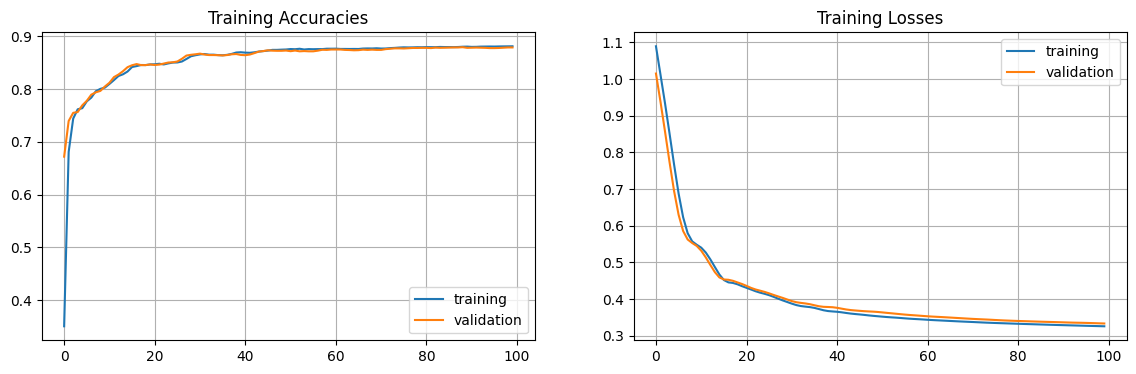

In [59]:
# Helper Function
def plot_results(ax, training, validation, title):
  ax.plot(training)
  ax.plot(validation)
  ax.legend(['training', 'validation'])
  ax.grid(True)
  ax.set_title(title)

# Print results
print(f"Training Accuracy:   {training['training_accuracy']}")
print(f"Validation Accuracy: {training['val_accuracy']}")
print(f"Testing Accuracy:    {testing['accuracy']}\n")

print(f"Training Loss:   {training['training_loss']}")
print(f"Validation Loss: {training['val_loss']}")
print(f"Testing Loss:    {testing['loss']}\n")

# Print Metrics for Test Results
print("Pred  class 0  class 1  class 2")
print("Actual")
print(f"{testing['confusion_matrix']}\n")
print(f"F1_Score: {testing['f1_score']}\n")
print(f"Recall Score: {testing['recall_score']}\n")
print(f"Precision Score: {testing['precision_score']}\n")


# Plot results
fig, ax = plt.subplots(1,2,figsize=(14,4))

plot_results(ax=ax[0], training=training['training_accuracies'], validation=training['val_accuracies'], title='Training Accuracies')
plot_results(ax=ax[1], training=training['training_losses'], validation=training['val_losses'], title='Training Losses')
plt.show()